Welcome to the Third Exercise Block

In this example, we will cover:

- Denoising/Smoothing (SM)
- Baseline correction (BC)
- Peak detection
- Peak integration

These kind of analysis methods can be relevant when depicting X-ray diffraction patterns, spectrograms obtained from various techniques (e.g. IR/Raman, UV/Vis, X-ray, NMR, ...), chromatograms and electropherograms and many more.

Often the experimental data is subject to noise or has a notable offset in the baseline.

SciPy offers a number of straighforward tools to quickly enhance the data to make it ready for plotting.

Let's start by reading in some X-ray diffraction data.


In [ ]:
try:
    import google.colab
    USE_COLAB = True
except:
    USE_COLAB = False
if USE_COLAB:
    from google.colab import files
    uploaded = files.upload()
else:
    # CHANGE THIS TO YOUR LOCAL PATH
    #path =  "../../data/exercises/X-ray_Diffraction/"
    # path to github repo
    path = "https://raw.githubusercontent.com/stkroe/PythonForChemists/main/course/data/exercises/X-ray_Diffraction/"


Saving XRD_experimental.dat to XRD_experimental.dat
Saving XRD_theory.dat to XRD_theory.dat


Next, we load [NumPy](https://numpy.org/) and [matplotlib](https://matplotlib.org/) so we can extract the data.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

xrd_exp = np.loadtxt('XRD_experimental.dat')
xrd_theo = np.loadtxt('XRD_theory.dat')

x_exp  = xrd_exp[:, 0]
y_exp  = xrd_exp[:, 1]

x_theo = xrd_theo[:, 0]
y_theo = xrd_theo[:, 1]

Let's have a quick look at the files ... just a raw plot (no labels, no fine-tuning).

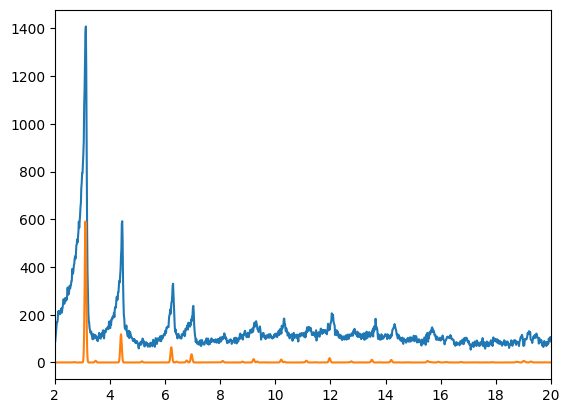

In [4]:
plt.plot(x_exp,  y_exp)
plt.plot(x_theo, y_theo)

xmin=2.0
xmax=20.0

plt.xlim(xmin, xmax)

plt.show()

Some findings:

- The XRD patterns have different height. Typically, the highest reflex is normalised to 100 so we can compare different methods.
- The experimental pattern has a lot of noice and the baseline is not aligning with zero:

Let's start with smoothing/denoising the plot using *gaussian_filter1d()* and peak detection using *find_peaks*

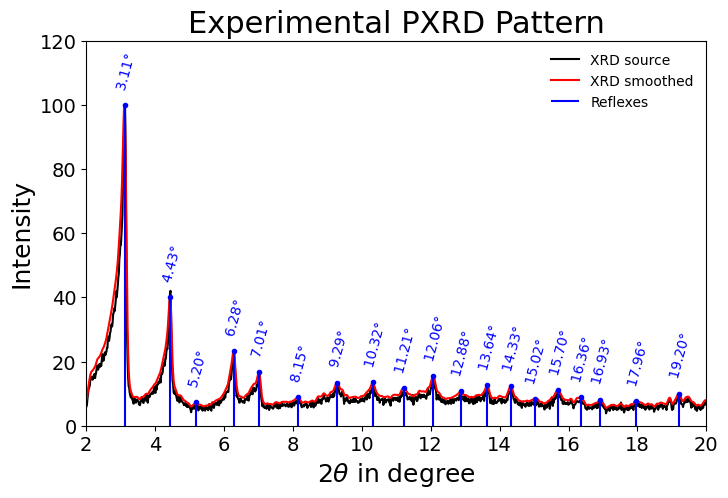

In [5]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

plt.figure(figsize = (8, 5) )

# This one-line command applies the smoothing/denoising
y_smooth = gaussian_filter1d(y_exp, sigma = 2)

# Normalizing the main reflex to a value of 100
y_smooth = 100 * y_smooth / np.max(y_smooth)
y_exp    = 100 * y_exp    / np.max(y_exp)

# This one-line command executes the peak detection
peaks, info = find_peaks(y_smooth, prominence = 0.75, distance = 35)

#Set up the plot
xmin = 2.0
xmax = 20.0

plt.xlim(xmin, xmax)
plt.ylim(0, 120)

# Let's overly the source and smoothed XRD
plt.plot(x_exp, y_exp, color='k', label="XRD source")
plt.plot(x_exp, y_smooth, color='r', label="XRD smoothed")

# Also, we show the positions of the detected reflexes and add vertical lines (drop lines)
# Careful: peaks is an 'index array' that tells us which entry of y_smooth corresponds
# to a peak position.
# To show the actual data points we have to use x_exp[peaks] and y_smooth[peaks]
plt.plot(x_exp[peaks], y_smooth[peaks], "o", color="b", markersize=3)
plt.vlines(x_exp[peaks], ymin=0, ymax=y_smooth[peaks], color='b', label="Reflexes" )

# Let's place a label on the reflexes using a loop.
# We print the x-value above the peak position
for p in range(len(peaks)):
  if x_exp[peaks[p]] < xmax:
    plt.text(x_exp[peaks[p]], y_smooth[peaks[p]], f"    {x_exp[peaks[p]]:.2f}°",
             fontsize = 10, ha = 'center', color = 'blue', rotation = 75)

# Add lables and titles, select font size
plt.xlabel(r'2$\theta$ in degree', fontsize=18)
plt.ylabel('Intensity', fontsize=18)
plt.title('Experimental PXRD Pattern', fontsize=22)

# Increase font size of axis labels
plt.tick_params(axis='both', labelsize=14)

plt.legend(loc='upper right', frameon=False)

plt.show()



This worked well, but the baseline is not aligned to zero.

Adding a baseline correction using *minimum_filter1d()* is straightforward as well.

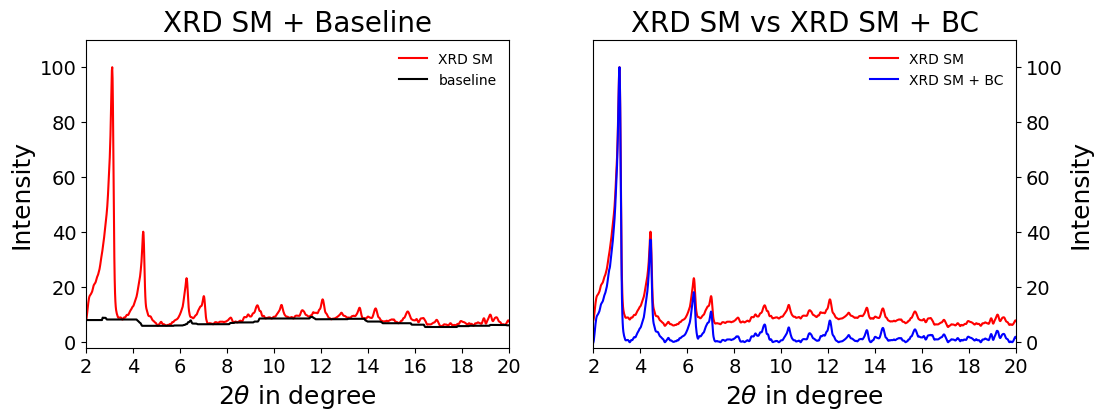

In [46]:
from scipy.ndimage import minimum_filter1d

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# This one-line command calculates a new baseline
baseline = minimum_filter1d(y_smooth, size=90)

# Now we only need to subtract the baseline from the smoothed y-data.
y_corr = y_smooth - baseline

# We need to normalize the main reflex to a value of 100 as before
y_corr = 100 * y_corr / np.max(y_corr)

# Set up the plot
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(-2, 110)

ax2.set_xlim(xmin, xmax)
ax2.set_ylim(-2, 110)

ax1.plot(x_exp, y_smooth, color='r', label="XRD SM")
ax1.plot(x_exp, baseline, color='k', label="baseline")

ax2.plot(x_exp, y_smooth, color='r', label="XRD SM")
ax2.plot(x_exp, y_corr, color='b', label="XRD SM + BC")


ax2.legend(frameon = False, loc = 'upper right')

for i in [ax1, ax2]:
  i.set_xlabel(r'2$\theta$ in degree', fontsize=18)
  i.set_ylabel('Intensity', fontsize=18)
  i.legend(frameon = False, loc = 'upper right')
  i.tick_params(axis='both', labelsize=14)
  i.set_xticks(np.arange(2, 20.0001, 2))

ax1.set_title('XRD SM + Baseline', fontsize=20)

ax2.set_title('XRD SM vs XRD SM + BC', fontsize=20)
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()

plt.show()

Does the baseline correction affacted our data?

Let's run another peak detection and compare, *e.g.* by drawing a correlation between the reflex positions before and after baseline correction.

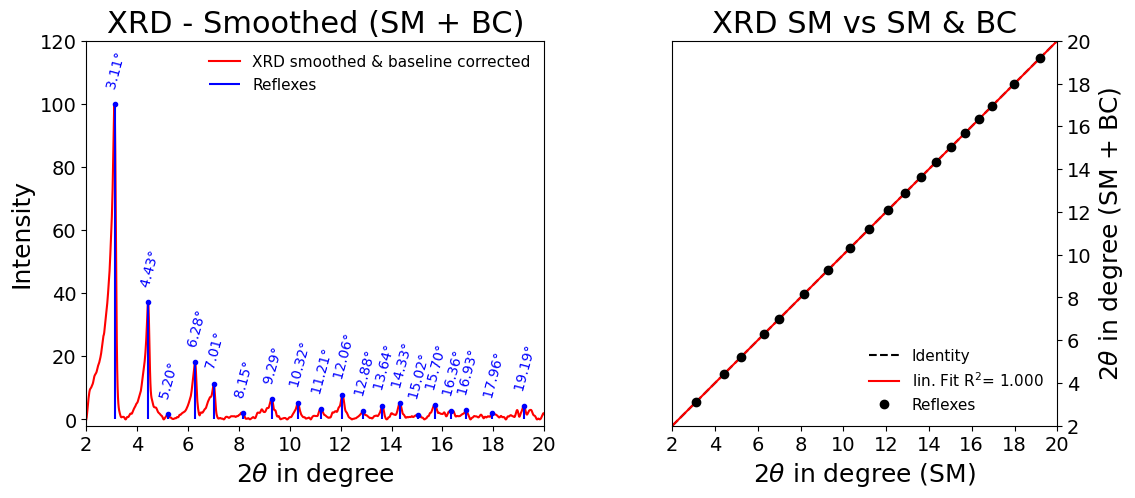

In [7]:
from scipy.stats import linregress

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Suplot 2 should be a correlation plot, so we set an aspect ratio of 1:1
ax2.set_aspect('equal')

# We again carry out a the peak detection on the data set after the
# baseline correction
peaks_corr, info_corr = find_peaks(y_corr,  prominence = 0.5, distance = 35)

# If we made sure that the same peaks are detected, we can apply
# a linear regression as we did before
reg = linregress(x_exp[peaks[0:19]], x_exp[peaks_corr[0:19]])

reg_limits = np.linspace(xmin, xmax, 2)

# Set up the plots
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(-2, 120)

ax2.set_xlim(xmin, xmax)
ax2.set_ylim(xmin, xmax)

# Let's draw again the XRD and add highlights for the reflex posittions
# and drop lines
ax1.plot(x_exp, y_corr, color='r', label="XRD smoothed & baseline corrected")
ax1.plot(x_exp[peaks_corr], y_corr[peaks_corr], "o", color="b", markersize=3)
ax1.vlines(x_exp[peaks_corr], ymin=0, ymax=y_corr[peaks_corr], color='b', label="Reflexes" )

# We label the peaks as before
for i in range(len(peaks_corr)):
  if x_exp[peaks_corr[i]] < xmax:
    ax1.text(x_exp[peaks_corr[i]], y_corr[peaks_corr[i]], f"    {x_exp[peaks_corr[i]]:.2f}°",
             fontsize=10, ha='center', color='blue', rotation=75)

# For the correlation we draw the ideal line, the regression and the data as points
ax2.plot([xmin, xmax], [xmin, xmax], color = 'k', linestyle = '--', label = "Identity")
ax2.plot(reg_limits, reg[0] * reg_limits + reg[1], color = 'r', label = f"lin. Fit R$^2$={reg[2]**2: 6.3f}")
ax2.plot(x_exp[peaks[0:19]], x_exp[peaks_corr[0:19]], marker = 'o', linestyle = ' ', color = 'k', label = "Reflexes")

# Addjust the plots by adding legend, labels and adjust the fontsizes
# and ticks
ax1.legend(frameon = False, loc = 'upper right', fontsize = 11)
ax2.legend(frameon = False, loc = 'lower right', fontsize = 11)

ax1.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='both', labelsize=14)

ax1.set_xlabel(fr'2$\theta$ in degree', fontsize=18)
ax1.set_ylabel(fr'Intensity', fontsize=18)
ax1.set_title('XRD - Smoothed (SM + BC)', fontsize=22)
ax1.set_xticks(np.arange(2, 20.0001, 2))

ax2.set_xlabel(fr'2$\theta$ in degree (SM)', fontsize=18)
ax2.set_ylabel(fr'2$\theta$ in degree (SM + BC)', fontsize=18)
ax2.set_title('XRD SM vs SM & BC', fontsize=22)

ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()

ax2.set_xticks(np.arange(2, 20.0001, step=2))
ax2.set_yticks(np.arange(2, 20.0001, step=2))

plt.show()

Repeating this process for the theoretical XRD is much easier, since neither a baseline corrcetion nor denoising is required!

Here, we make manual adjustments to make sure the same reflexes are used as in the experimental reference.

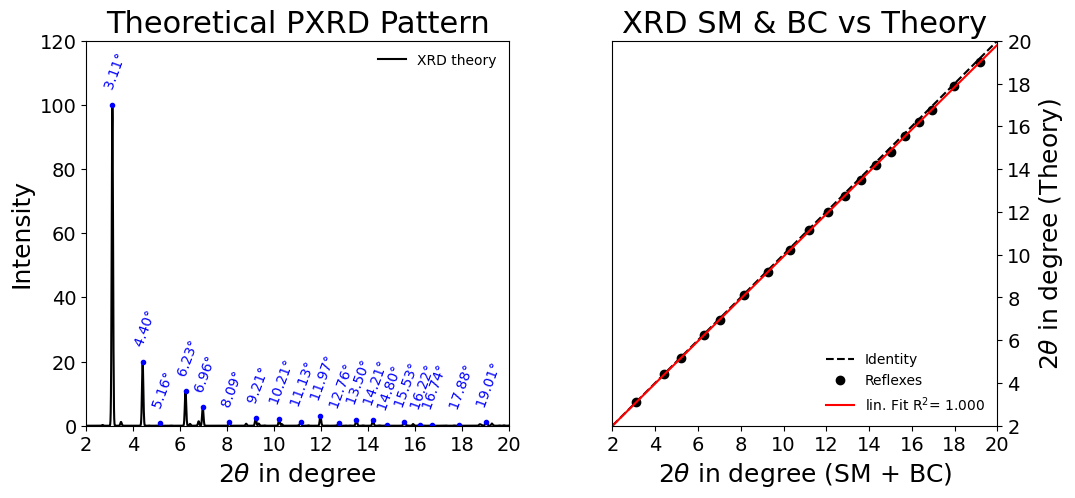

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax2.set_aspect('equal')

# We can directly normalize the theoretical XRD pattern
# No smoothing or baseline correction required
y_theo = 100 * y_theo/ np.max(y_theo)

# Peak detection for the theoretical XRD as before
peaks_theo, info_theo = find_peaks(y_theo, prominence = 0.1, distance = 50)

# Now we can create a regression between the XRD (SM + BC) vs theory
reg2 = linregress(x_exp[peaks_corr[0:19]], x_theo[peaks_theo[0:19]])

# Set up the plot
xmin=2.0
xmax=20.0

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(0, 120)

ax2.set_xlim(xmin, xmax)
ax2.set_ylim(xmin, xmax)

# Show the theoretical XRD and the reflex peaks
# The data is so narrow drop lines are not required here
ax1.plot(x_theo, y_theo, color='k', label="XRD theory")
ax1.plot(x_theo[peaks_theo[0:19]], y_theo[peaks_theo[0:19]], "o", color="b", markersize=3)

# Label the reflexes as before
for i in range(len(peaks_theo[0:19])):
  if x_theo[peaks_theo[i]] < xmax:
    ax1.text(x_theo[peaks_theo[i]], y_theo[peaks_theo[i]], f"    {x_theo[peaks_theo[i]]:.2f}°",
             fontsize = 10, ha = 'center', color = 'blue', rotation = 70)

# Generate the correlation plot as before
ax2.plot([xmin, xmax], [xmin, xmax], color = 'k', linestyle = '--', label = "Identity")
ax2.plot(x_exp[peaks_corr[0:19]], x_theo[peaks_theo[0:19]], marker = 'o', linestyle = ' ', color = 'k', label = "Reflexes")
ax2.plot(reg_limits, reg2[0] * reg_limits + reg2[1], color = 'r', label = f"lin. Fit R$^2$={reg2[2]**2: 6.3f}")

# Add lables and titles, select font size
ax1.set_xlabel(r'2$\theta$ in degree', fontsize=18)
ax1.set_ylabel('Intensity', fontsize=18)
ax1.set_title('Theoretical PXRD Pattern', fontsize=22)
ax1.set_xticks(np.arange(2, 20.0001, 2))

# Increase font size of axis labels
ax1.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='both', labelsize=14)

ax1.legend(loc='upper right', frameon=False)
ax2.legend(loc='lower right', frameon=False)

ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()

ax2.set_xlabel(fr'2$\theta$ in degree (SM + BC)', fontsize=18)
ax2.set_ylabel(fr'2$\theta$ in degree (Theory)', fontsize=18)
ax2.set_title('XRD SM & BC vs Theory', fontsize=22)

ax2.set_xticks(np.arange(2, 20.0001, step=2))
ax2.set_yticks(np.arange(2, 20.0001, step=2))

plt.show()

Let's compare the deviations in the reflex positions between the theoretical and experimental data.

We can customize the output anyway we want, *e.g.* directly in a format compatible with LaTeX tables:

In [44]:

print("---------------------------------------------------------------------")
print('     &   2θ(Exp.)  &  2θ(Theory)  &    Δ(2θ)   &  rel. Dev. in %  \\\\ ')
print("---------------------------------------------------------------------")
for i in np.arange(0, 19):
  print(f'{i+1:3d}  &    {x_exp[peaks_corr[i]]:5.2f}    &     {x_theo[peaks_theo[i]]:5.2f}    &   {x_theo[peaks_theo[i]] - x_exp[peaks_corr[i]]:6.3f}   &       {(x_theo[peaks_theo[i]] - x_exp[peaks_corr[i]])/x_exp[peaks[i]]*100.0:5.2f}      \\\\' )

print("---------------------------------------------------------------------")


---------------------------------------------------------------------
     &   2θ(Exp.)  &  2θ(Theory)  &    Δ(2θ)   &  rel. Dev. in %  \\ 
---------------------------------------------------------------------
  1  &     3.11    &      3.11    &    0.000   &        0.00      \\
  2  &     4.43    &      4.40    &   -0.030   &       -0.68      \\
  3  &     5.20    &      5.16    &   -0.035   &       -0.67      \\
  4  &     6.28    &      6.23    &   -0.045   &       -0.72      \\
  5  &     7.01    &      6.96    &   -0.050   &       -0.71      \\
  6  &     8.15    &      8.09    &   -0.060   &       -0.74      \\
  7  &     9.29    &      9.21    &   -0.080   &       -0.86      \\
  8  &    10.32    &     10.21    &   -0.115   &       -1.11      \\
  9  &    11.21    &     11.13    &   -0.080   &       -0.71      \\
 10  &    12.06    &     11.97    &   -0.095   &       -0.79      \\
 11  &    12.88    &     12.76    &   -0.115   &       -0.89      \\
 12  &    13.64    &     13.50 

Let's bring it home by preparing a plot comparing the smoothed, baseline-corrected experimental with the theoretical pattern.

To do this we define a suitable *offset* value. In this example, the experimental pattern is shifted in *z*-direction.

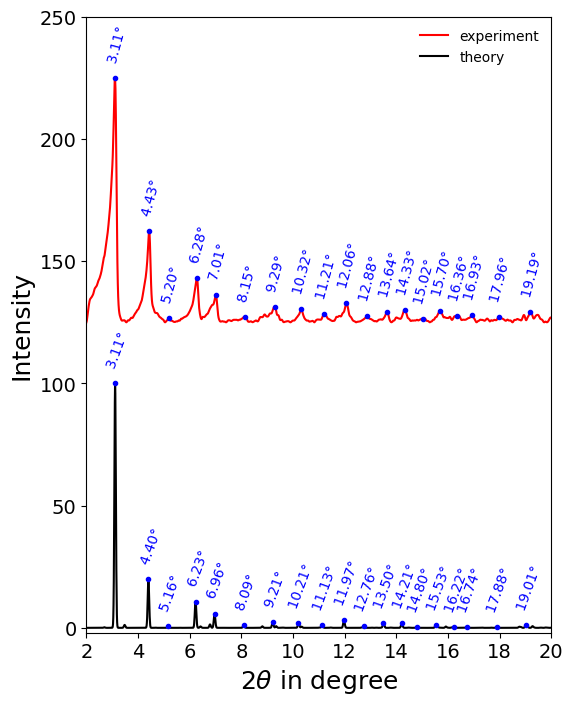

In [45]:
plt.figure(figsize = (6, 8) )

offset=125

plt.plot(x_exp, y_corr + offset, color='r', label="experiment")
plt.plot(x_exp[peaks_corr], y_corr[peaks_corr] + offset, "o", color="b", markersize=3)

for i in range(len(peaks_corr)):
  if x_exp[peaks_corr[i]] < xmax:
    plt.text(x_exp[peaks_corr[i]], y_corr[peaks_corr[i]]+ offset, f"    {x_exp[peaks_corr[i]]:.2f}°",
             fontsize=10, ha='center', color='blue', rotation=75)


plt.plot(x_theo, y_theo, color='k', label="theory")
plt.plot(x_theo[peaks_theo[0:19]], y_theo[peaks_theo[0:19]], "o", color="b", markersize=3)

for i in range(len(peaks_theo[0:19])):
  if x_theo[peaks_theo[i]] < xmax:
    plt.text(x_theo[peaks_theo[i]], y_theo[peaks_theo[i]], f"    {x_theo[peaks_theo[i]]:.2f}°",
             fontsize = 10, ha = 'center', color = 'blue', rotation = 70)

plt.xlim(xmin, xmax)
plt.ylim(-2, 250)

# Add lables and titles, select font size
plt.xlabel(r'2$\theta$ in degree', fontsize=18)
plt.ylabel('Intensity', fontsize=18)
#plt.title('XRD - Experimental vs. Theory', fontsize=22)
plt.xticks(np.arange(2, 20.0001, 2))

# Increase font size of axis labels
plt.tick_params(axis='both', labelsize=14)

plt.legend(loc='upper right', frameon=False)

plt.show()
